In [9]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
from scipy.io import loadmat
import random
import IPython
import yaml
from pathlib import Path

from homtools import get_eigenmike, reduced_eigenmike
from shtools import sound_pressure_from_hoa, get_real_sh
from utils import mystft, multichannel_fft_convolve, trim_signal_to_activity

draw = True  # Whether to plot or not
CONFIG_FILE_PATH = 'config.yaml'
try:
    with open(CONFIG_FILE_PATH, 'r') as file:
        # It's recommended to use yaml.safe_load() for security
        # as yaml.load() can execute arbitrary code.
        config = yaml.safe_load(file)
    print("YAML file loaded successfully!")
    # print(config) # Uncomment to see the full dictionary
except FileNotFoundError:
    print(f"Error: The file {CONFIG_FILE_FILE_PATH} was not found.")
    config = None
except yaml.YAMLError as exc:
    print(f"Error parsing YAML file: {exc}")
    config = None

# Set random seed for reproducibility
random.seed(42)
target_room_id = 1
target_rir_id = 4

# === Paths ===
audio_dir = config['rutas']['audio_dir']
csv_room =  glob.glob(config['rutas']['csv_dir'] + "/room_info_*.csv")[0]
csv_rir =  glob.glob(config['rutas']['csv_dir'] + "/rir_info_*.csv")[0]
srir_dir = config['rutas']['srir_dir']
srir_type = config['rutas']['srir_type']

# User parameters from config file
c = config['general']['c']
fs = config['general']['fs']
winlen = config['general']['winlen']
sh_order = config['hoa_encoding']['sh_order']
Q = (sh_order + 1) ** 2
b_n_len = config['hoa_encoding']['b_n_len']

# Mic angles
hom = get_eigenmike(config['eigenmike']['mic_r'],
                    config['eigenmike']['mic_az'],
                    config['eigenmike']['mic_el'],
                    config['eigenmike']['gain'],
                    config['eigenmike']['w'],
                    isRigid=config['eigenmike']['micType']=='rigid')
# hom = reduced_eigenmike(Q, hom=hom_full)

YAML file loaded successfully!


### Get 5 seconds from a random audio file according to the selected room and rir
Note: Look the signal and pick 5 seconds where the source is active

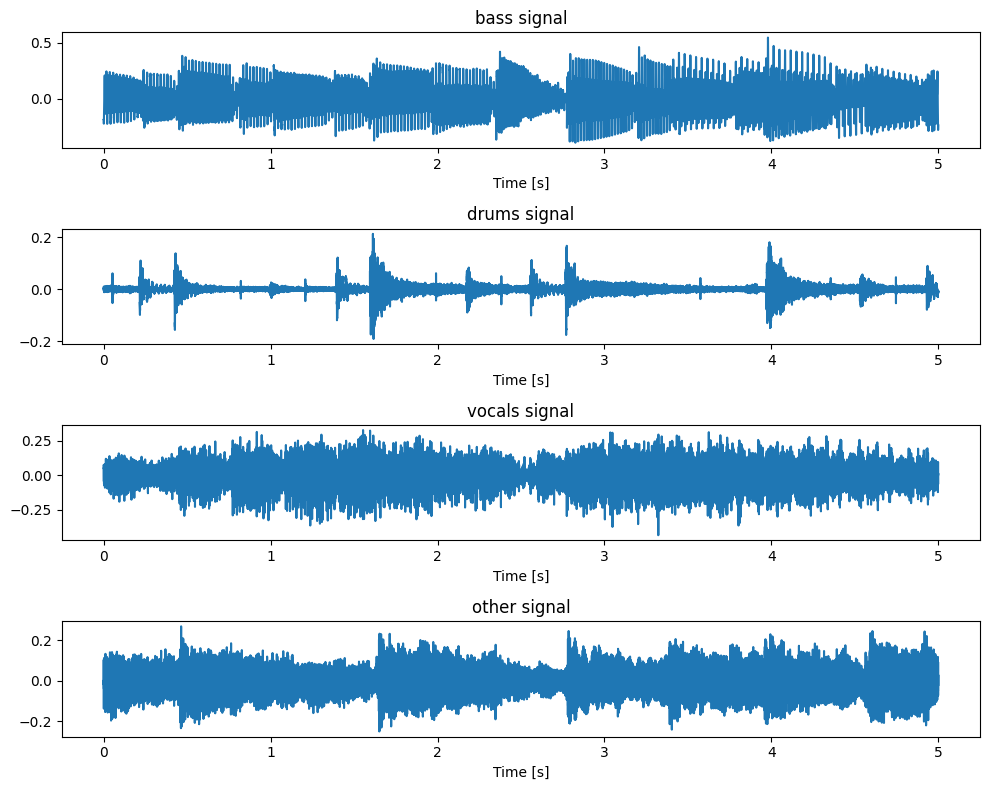

In [10]:
# Read RIR info
rir_info = pd.read_csv(csv_rir)

# Get subfolders (each one is a song)
audio_dirs = sorted([f for f in Path(audio_dir).iterdir() if f.is_dir()])
audio_info = []

# CAREFUL - Limit to first 1 for testing
audio_dirs = [audio_dirs[0]] 
for i, folder in enumerate(audio_dirs):
    song_id = f"train_{i+1}"

    # Load mono sources
    signals, valid_starts = [], []
    first_iter = True
    min_len = np.inf
    for name in ['bass', 'drums', 'vocals', 'other']:
        x, _ = sf.read(folder / f"{name}.wav")
        if x.ndim > 1:
            x = x[:, 0]
        signals.append(x)
        min_len = min(min_len, len(x))
        # Find valid start indices
        if first_iter:
            first_iter = False
            valid_start_idx = trim_signal_to_activity(x, fs)
        else:
            valid_start_idx  = np.intersect1d(valid_start_idx, trim_signal_to_activity(x, fs)) 

    # Trim to shortest length
    start_idx = np.random.choice(valid_start_idx)
    end_idx = min(start_idx + int(5 * fs), min_len)
    segment = [x[start_idx:end_idx] for x in signals] 
    
    # Draw signals and selected intervals
    if draw:
        fig, axs = plt.subplots(4, 1, figsize=(10, 8))
        time = np.arange(len(segment[0])) / fs
        for ax, sig, name in zip(axs, segment, ['bass', 'drums', 'vocals', 'other']):
            ax.plot(time, sig)
            ax.set_title(f"{name} signal")
            ax.set_xlabel("Time [s]")
        plt.tight_layout()
        plt.show()

### Estimate the signal in A and B format using the stored RIRs/SRIRs

In [11]:
# Random room and RIRs
available_rooms = rir_info['room_id'].unique()
# CAREFUL 
target_room_id = 1 # random.choice(available_rooms)
available_rirs = rir_info[rir_info['room_id'] == target_room_id]['rir_id'].values
# CAREFUL 
target_rir_id = [1,2,3,4] # random.sample(list(available_rirs), 4)

# Convolve
signal_src = []
signal_src_hoa = []
signal_mix = None
signal_mix_hoa = None

for sidx, signal in enumerate(segment):
   rir_name = f"room{target_room_id}_{target_rir_id[sidx]}"
   print(rir_name)
   audio_info.append([song_id, str(folder / f"{sidx+1}"), f"{target_room_id}_{target_rir_id[sidx]}"])
   print([song_id, str(folder / f"{sidx+1}"), f"{target_room_id}_{target_rir_id[sidx]}"])

   # Get azimuth and elevation info
   row_idx = np.where((rir_info['room_id'] == target_room_id) &
                     (rir_info['rir_id'] == target_rir_id[sidx]))[0]

   if row_idx.size > 0:
      az_deg = np.degrees(rir_info['az'][row_idx])
      el_deg = np.degrees(rir_info['el'][row_idx])
      print(f"Current azimuth = {az_deg._values[0]:.2f}º, elevation = {el_deg._values[0]:.2f}º")
   else:
      print("No matching RIR found.")

   # Load RIRs
   if srir_type == 'clean':
        sim_rir=loadmat(os.path.join(srir_dir, f"{rir_name}_clean.mat"))['sim_rir_clean'].astype(np.float64)
        rir_hoa = loadmat(os.path.join(srir_dir, f"hoa_{rir_name}_clean.mat"))['rir_hoa'].astype(np.float64)
   else:
        sim_rir=loadmat(os.path.join(srir_dir, f"{rir_name}.mat"))['sim_rir'].astype(np.float64)
        rir_hoa = loadmat(os.path.join(srir_dir, f"hoa_{rir_name}.mat"))['rir_hoa'].astype(np.float64)
     
   if hom.emReference is not None:
      sim_rir = sim_rir[hom.emReference, :]
    
   # Do the first convolution just to get the length
   signal_tmp = multichannel_fft_convolve(sim_rir, signal)
   signal_tmp_hoa = multichannel_fft_convolve(rir_hoa, signal)

   # GT signals
   signal_src.append(signal_tmp)
   signal_src_hoa.append(signal_tmp_hoa)

   # Save the individual source signal
   if signal_mix is None:
      signal_mix = np.zeros_like(signal_tmp)
   signal_mix += signal_tmp

   if signal_mix_hoa is None:
      signal_mix_hoa = np.zeros_like(signal_tmp_hoa)
   signal_mix_hoa += signal_tmp_hoa

room1_1
['train_1', '/Users/carabias/Development/smir_simulator/signals/A Classic Education - NightOwl/1', '1_1']
Current azimuth = 7.19º, elevation = 112.93º
room1_2
['train_1', '/Users/carabias/Development/smir_simulator/signals/A Classic Education - NightOwl/2', '1_2']
Current azimuth = 33.47º, elevation = 87.86º
room1_3
['train_1', '/Users/carabias/Development/smir_simulator/signals/A Classic Education - NightOwl/3', '1_3']
Current azimuth = 15.52º, elevation = 73.50º
room1_4
['train_1', '/Users/carabias/Development/smir_simulator/signals/A Classic Education - NightOwl/4', '1_4']
Current azimuth = 92.55º, elevation = 115.95º


### BEAMFORMING TEST

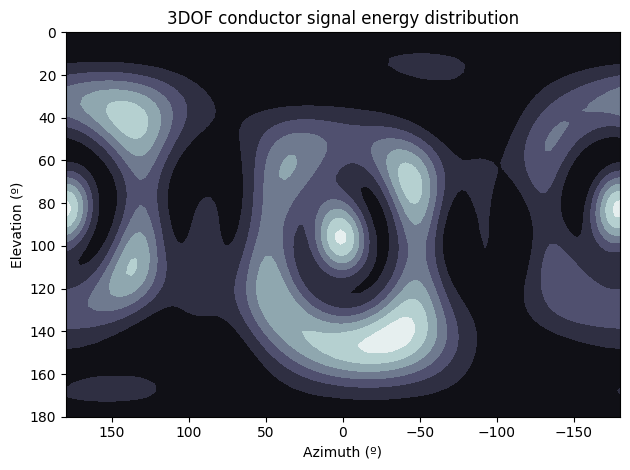

In [12]:
# Beamformer (sin normalizar) a todas las posiciones del espacio
theta,phi = np.linspace(0,np.pi,60), np.linspace(-np.pi,np.pi,120)
theta_mesh,phi_mesh = np.meshgrid(
    theta,
    phi
)

beamformer_order = config['hoa_encoding']['beamformer_order']
Y_l = get_real_sh(beamformer_order, theta_mesh.flatten(), phi_mesh.flatten())
energy = np.apply_along_axis(
    lambda arr: arr@arr/len(arr),
    1,
    Y_l.T @ signal_mix_hoa[:(beamformer_order+1)**2,:]
).real

fig,ax = plt.subplots()
ax.contourf(
    np.degrees(phi_mesh),
    np.degrees(theta_mesh),
    np.reshape(energy,phi_mesh.shape),
    cmap='bone'
)
ax.set_title('3DOF conductor signal energy distribution')
ax.set_xlabel('Azimuth (º)')
ax.set_ylabel('Elevation (º)')
ax.invert_xaxis()
ax.invert_yaxis()
fig.tight_layout()

### Now let's go back from HOA to the original A-format and check the SNR

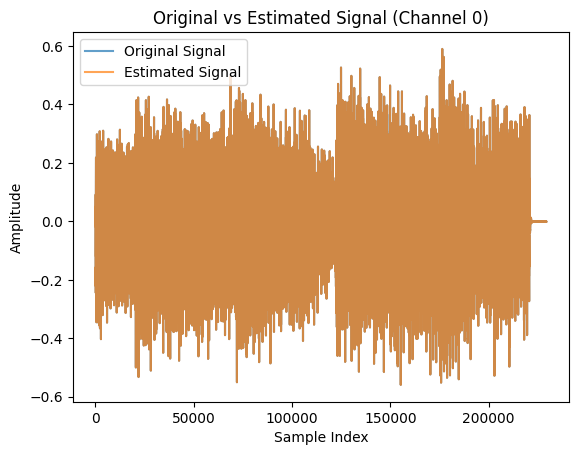

SNR = 79.02 dB


In [13]:
# Spherical harmonics decomposition (STFT of HOA signals)  
signal_est=sound_pressure_from_hoa(signal_mix_hoa, fs, sh_order, hom.r, hom.az, hom.el, hom.isRigid, b_n_len)
# Compenso el retardo de las dos convoluciones 2048 muestras
signal_est = signal_est[:,b_n_len:]

# Take reference signal as the mixture in A-format
signal_ref = signal_mix

# Ensure both signals are the same length and shape
min_len = min(signal_ref.shape[1], signal_est.shape[1])
signal_orig = signal_ref[:, :min_len]
signal_est = signal_est[:, :min_len]

# Compute noise
noise = signal_ref - signal_est

# Compute SNR in dB
snr_value = 10 * np.log10(np.sum(signal_ref**2) / np.sum(noise**2))

# Print both signals signal_est and signal_orig overlapped plot
plt.figure()
plt.plot(signal_ref[0, :], label='Original Signal', alpha=0.7)
plt.plot(signal_est[0, :], label='Estimated Signal', alpha=0.7)
plt.title('Original vs Estimated Signal (Channel 0)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

IPython.display.display(IPython.display.Audio(signal_est[0, :], rate=fs))
IPython.display.display(IPython.display.Audio(signal_orig[0, :], rate=fs))

print(f"SNR = {snr_value:.2f} dB")